In [1]:
# Imports and configuration
%load_ext autoreload
%autoreload 2

import pandas as pd
import src.utils.file_utils as fu
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in raw data file
typed_hmda_data = fu.load_parquet("hmda_2024_typed")
print(typed_hmda_data.shape)

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/interim/hmda_2024_typed.parquet
(8841112, 76)


In [3]:
# Verify target variable is binary
typed_hmda_data["denied_flag"].dtype

bool[pyarrow]

In [4]:
# Verify target variable values are all populated True/False
typed_hmda_data["denied_flag"].value_counts()

denied_flag
False    6693164
True     2147948
Name: count, dtype: int64[pyarrow]

In [5]:
# Target variable class proportions
proportions = typed_hmda_data["denied_flag"].value_counts(normalize=True)
proportions

denied_flag
False    0.75705
True     0.24295
Name: proportion, dtype: double[pyarrow]

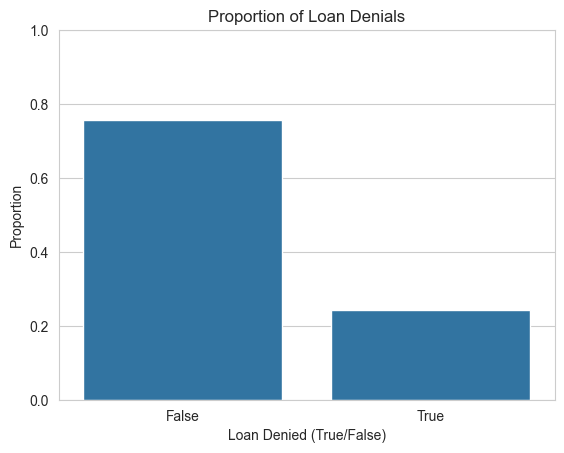

In [6]:
# Convert to DataFrame for seaborn
proportions_df = proportions.reset_index()
proportions_df.columns = ['is_denied', 'proportion']

# Get the output path
graph_output_path = fu.get_path("target_class_balance_graph")

# Create the bar plot
sns.barplot(data=proportions_df, x='is_denied', y='proportion')

plt.title('Proportion of Loan Denials')
plt.ylabel('Proportion')
plt.xlabel('Loan Denied (True/False)')
plt.ylim(0, 1)
plt.savefig(graph_output_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [7]:
# Dataset is imbalanced; may require class weighting or resampling later